In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


## 데이터 로드

In [ ]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder

sns.set(style="darkgrid")
warnings.filterwarnings(action='ignore') # 경고 무시

# 경로
data_path = '/kaggle/input/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

## 다운캐스팅
 출처 : [https://www.kaggle.com/code/jungbyunggil/top-3-5-lightgbm-with-feature-engineering/edit]

In [ ]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


## 작성 시 사용할 수 있는 유틸리티 기능들
출처 : [https://www.kaggle.com/code/abubakar624/first-place-solution-kaggle-predict-future-sales]

In [ ]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

## sales_train 의 이상치 제거

<AxesSubplot:xlabel='item_price'>

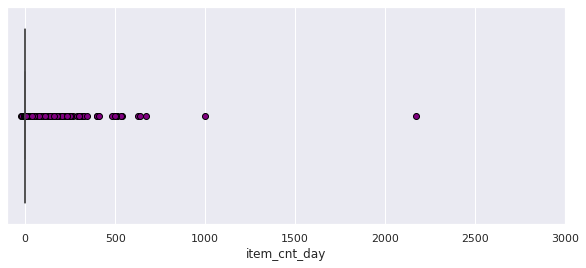

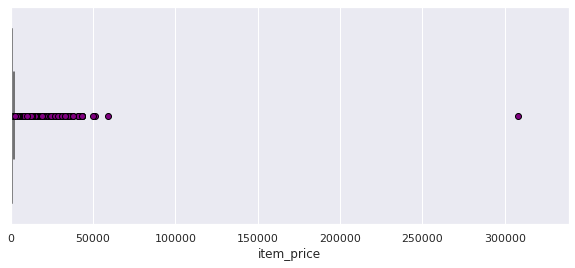

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales_train.item_price.min(), sales_train.item_price.max()*1.1)
sns.boxplot(x=sales_train.item_price, flierprops=flierprops)

In [ ]:
# 아이템 가격이 0보다 작은 값 제외
sales_train = sales_train[sales_train['item_price'] > 0]
# 100000 이상 나온 가격 제외
sales_train = sales_train[sales_train['item_price'] < 100000]
# 아이템 판매량이 0보다 작은 값 제외
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# 판매량이 1000 이상일 경우 제외
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [ ]:
#  id_name이 같은 값들의 id 변경
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40
sales_train.loc[sales_train['shop_id'] == 37, 'shop_id'] = 36  # 수윤 수정 :Shop36 added separately because it only has one month of data

#  테스트 데이터에도 적용
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40
test.loc[test['shop_id'] == 37, 'shop_id'] = 36  # 수윤 수정 :Shop36 added separately because it only has one month of data

In [ ]:
# 중복값 제거
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]

## 진호님 작성 부분

In [ ]:
df_eda = pd.merge(sales_train, shops, how='left', left_on = 'shop_id', right_on = 'shop_id')
df_eda = pd.merge(df_eda, items, how='left', left_on='item_id', right_on='item_id')
df_eda = pd.merge(df_eda, item_categories, how='left', left_on='item_category_id', right_on='item_category_id')
df_eda.drop(['item_id', 'item_category_id', 'shop_id'], axis=1, inplace=True)
df_eda.head()

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name
0,02.01.2013,0,999.000000,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray
1,03.01.2013,0,899.000000,1,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил
2,06.01.2013,0,1709.050049,1,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,Музыка - Винил
3,15.01.2013,0,1099.000000,1,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),Музыка - CD фирменного производства
4,10.01.2013,0,349.000000,1,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,Музыка - Музыкальное видео


In [ ]:
df_eda['date'] = pd.to_datetime(df_eda['date'])
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2427356 entries, 0 to 2427355
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int8          
 2   item_price          float32       
 3   item_cnt_day        int16         
 4   shop_name           object        
 5   item_name           object        
 6   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1), object(3)
memory usage: 108.8+ MB


In [ ]:
#고유 가게이름 갯수
print(df_eda['shop_name'].unique())

#고유 가게이름 리스트
print(*df_eda['shop_name'].unique(), sep='\n')

['Ярославль ТЦ "Альтаир"' 'Москва ТРК "Атриум"'
 'Москва ТК "Буденовский" (пав.К7)' 'Курск ТЦ "Пушкинский"'
 'Москва Магазин С21' 'Красноярск ТЦ "Июнь"' 'Москва МТРЦ "Афи Молл"'
 'Москва ТЦ "МЕГА Теплый Стан" II' 'Москва ТЦ "Ареал" (Беляево)'
 'Волжский ТЦ "Волга Молл"' 'Воронеж (Плехановская, 13)'
 'Адыгея ТЦ "Мега"' 'Балашиха ТРК "Октябрь-Киномир"'
 'Воронеж ТРЦ "Максимир"' 'Якутск Орджоникидзе, 56'
 'Якутск ТЦ "Центральный"' 'Коломна ТЦ "Рио"' 'Калуга ТРЦ "XXI век"'
 'Жуковский ул. Чкалова 39м²' 'Казань ТЦ "ПаркХаус" II'
 'Интернет-магазин ЧС' 'Уфа ТЦ "Семья" 2' 'Москва ТЦ "Семеновский"'
 'Н.Новгород ТРЦ "Фантастика"' 'Чехов ТРЦ "Карнавал"'
 'Сургут ТРЦ "Сити Молл"' 'Тюмень ТЦ "Гудвин"' 'СПб ТК "Невский Центр"'
 'Уфа ТК "Центральный"' 'РостовНаДону ТЦ "Мега"' 'Омск ТЦ "Мега"'
 'Самара ТЦ "Мелодия"' 'Новосибирск ТРЦ "Галерея Новосибирск"'
 'Сергиев Посад ТЦ "7Я"' 'Самара ТЦ "ПаркХаус"' 'Вологда ТРЦ "Мармелад"'
 'Цифровой склад 1С-Онлайн' 'Тюмень ТРЦ "Кристалл"'
 'РостовНаДону ТРК "Ме

In [ ]:
#도시 나누기
cities = []
for i in df_eda['shop_name']:
    city = i.split(' ')[0]
    if city[0] == '!':
        city = i.split('!')[1].split(' ')[0]
        cities.append(city)
    elif city == 'Интернет-магазин':
        cities.append('Интернет')
    elif city == 'Цифровой':
        cities.append('Интернет')
    else:
        cities.append(city)

In [ ]:
df_eda['city'] = cities
df_eda.head(3)

,date,date_block_num,item_price,item_cnt_day,shop_name,item_name,item_category_name,city
0,2013-02-01,0,999.000000,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,Ярославль
1,2013-03-01,0,899.000000,1,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,Музыка - Винил,Москва
2,2013-06-01,0,1709.050049,1,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,Музыка - Винил,Москва


In [ ]:
# 고유 도시이름 리스트
df_eda['city'].unique()

array(['Ярославль', 'Москва', 'Курск', 'Красноярск', 'Волжский',
       'Воронеж', 'Адыгея', 'Балашиха', 'Якутск', 'Коломна', 'Калуга',
       'Жуковский', 'Казань', 'Интернет', 'Уфа', 'Н.Новгород', 'Чехов',
       'Сургут', 'Тюмень', 'СПб', 'РостовНаДону', 'Омск', 'Самара',
       'Новосибирск', 'Сергиев', 'Вологда', 'Томск'], dtype=object)

In [ ]:
#상품 많이 팔린 도시 순위 10위까지
top_10_selling_freq_city = df_eda['city'].value_counts().head(10)
top_10_selling_city = df_eda['item_cnt_day'].groupby(df_eda['city']).sum().sort_values(ascending=False).head(10)

top_10_selling_city = top_10_selling_city.to_frame().reset_index()
top_10_selling_freq_city = top_10_selling_freq_city.to_frame().reset_index()
top_10_selling_city.columns = ['city', 'celling_count']
top_10_selling_freq_city.columns = ["city", "cell_freq_count"]

In [ ]:
print(top_10_selling_city.head())
print(top_10_selling_freq_city.head())

       city  celling_count
0    Москва       999276.0
1    Якутск       241348.0
2   Воронеж       167916.0
3       СПб       145195.0
4  Интернет       134210.0
      city  cell_freq_count
0   Москва           773041
1   Якутск           203917
2  Воронеж           140379
3      СПб           109002
4      Уфа            96117


In [ ]:
#퍼신티지로 나타내기
# top10 도시의 합
sell_sum = top_10_selling_city['celling_count'].sum()
freq_sum = top_10_selling_freq_city['cell_freq_count'].sum()

# 도시 판매량 / 전체 판매량
sell_percentage = []
freq_percentage = []
for i in top_10_selling_city['celling_count']:
    sell_percentage.append(i/sell_sum*100)
for i in top_10_selling_freq_city['cell_freq_count']:
    freq_percentage.append(i/freq_sum*100)
    

# 퍼신티지 열 생성
top_10_selling_city['celling_percentage'] = sell_percentage
top_10_selling_freq_city['cell_freq_percentage'] = freq_percentage

del sell_percentage, freq_percentage
gc.collect()

print(top_10_selling_city)
print(top_10_selling_freq_city)

       city  celling_count  celling_percentage
0    Москва       999276.0           46.746955
1    Якутск       241348.0           11.290458
2   Воронеж       167916.0            7.855249
3       СПб       145195.0            6.792342
4  Интернет       134210.0            6.278454
5       Уфа       111708.0            5.225792
6    Тюмень        93501.0            4.374054
7    Самара        87106.0            4.074890
8   Сергиев        79092.0            3.699989
9     Чехов        78276.0            3.661816
       city  cell_freq_count  cell_freq_percentage
0    Москва           773041             45.930031
1    Якутск           203917             12.115676
2   Воронеж           140379              8.340582
3       СПб           109002              6.476326
4       Уфа            96117              5.710767
5    Тюмень            80850              4.803682
6    Самара            75153              4.465196
7     Чехов            69378              4.122076
8  Интернет            6

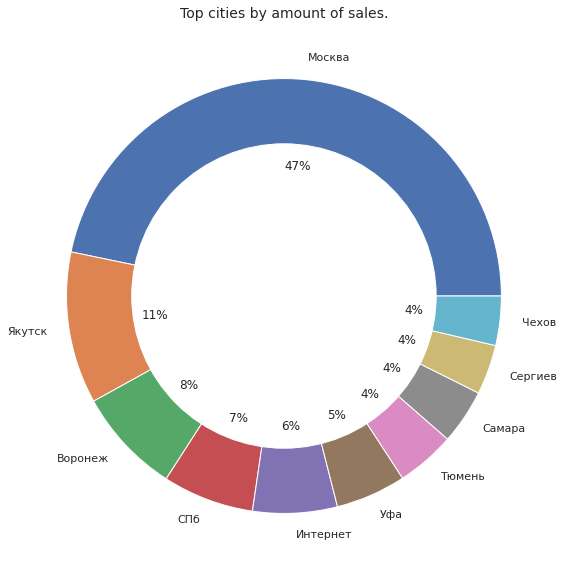

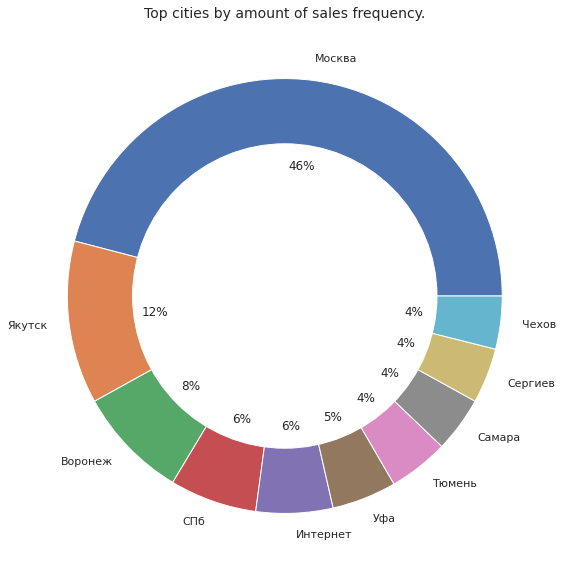

In [ ]:
plt.figure(figsize=(10,10))
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.pie(top_10_selling_city['celling_percentage'], labels=list(top_10_selling_city.city),
        explode=explode, autopct='%.0f%%')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Top cities by amount of sales.', fontdict={'size':14})

plt.figure(figsize=(10,10))
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.pie(top_10_selling_freq_city['cell_freq_percentage'], labels=list(top_10_selling_city.city),
        explode=explode, autopct='%.0f%%')
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Top cities by amount of sales frequency.', fontdict={'size':14})

plt.show()

In [ ]:
#모스크바가 유의미한 판매량을 가진 도시이기 때문에
#모스크바에서 제일 많이 팔린 판매량을 feature로 만들자.
#all_data에 innerjoin으로 city열을 추가한 다음 groupby로 모스크바 판매량을 나열한 리스트를 feature로

## item

### cleaning - item_name

In [ ]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
# 괄호에 따라 name split
items["name"], items["item_cat_1"] = items.item_name.str.split("[", 1).str
items["name"], items["item_cat_2"] = items.item_name.str.split("(", 1).str

# 소문자로, 특수문자 제거
items["item_cat_1"] = items.item_cat_1.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["item_cat_2"] = items.item_cat_2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# null 값에 0
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.item_cat_1 = items.item_cat_1.apply( lambda x: x[:-1] if x !="0" else "0")

### Clean item type

In [ ]:
items["type"] = items.item_cat_1.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [ ]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.item_cat_1 = items.item_cat_1.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

del drop_cols

In [ ]:
# 해당 상품이 처음으로 팔린 달
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_date'] = items['first_sale_date'].fillna(34) # 팔린 적 없으면 34

In [ ]:
items.item_cat_1 = LabelEncoder().fit_transform(items.item_cat_1)
items.item_cat_2 = LabelEncoder().fit_transform(items.item_cat_2)

items.drop(["item_name", "name"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,item_cat_1,item_cat_2,first_sale_date
0,0,40,4,1331,34.0
1,1,76,64,42,15.0
2,2,40,4,1011,34.0
3,3,40,4,1010,34.0
4,4,40,4,1572,34.0


## shop

In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'

In [ ]:
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["shops_category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [ ]:
# top_10_selling merge
shops = shops.merge(top_10_selling_city, on='city', how='left')

In [ ]:
# 수윤님 추가내용
city10 = top_10_selling_city['city']
shops["city"].apply(lambda x: 'others' if x not in city10.values else x)

0      Якутск
1      Якутск
2      others
3      others
4      others
5      others
6     Воронеж
7     Воронеж
8     Воронеж
9      others
10     others
11     others
12     others
13     others
14     others
15     others
16     others
17     others
18     others
19     others
20     Москва
21     Москва
22     Москва
23     Москва
24     Москва
25     Москва
26     Москва
27     Москва
28     Москва
29     Москва
30     Москва
31     Москва
32     Москва
33     others
34     others
35     others
36     others
37     others
38     others
39     others
40     others
41     others
42        СПб
43        СПб
44     Самара
45     Самара
46     others
47     others
48     others
49     Тюмень
50     Тюмень
51     Тюмень
52        Уфа
53        Уфа
54     others
55     others
56      Чехов
57     Якутск
58     Якутск
59     others
Name: city, dtype: object

In [ ]:
city_mapping = {'others':0, 'Чехов':1, 'Сергиев':2, 'Самара':3, 'Тюмень':4, 'Уфа':5, 'Интернет':6, 'СПб':7, 'Воронеж':8, 'Якутск':9, 'Москва':10}
shops['city'] = shops['city'].map(city_mapping)
shops['city'] = shops['city'].astype(int)

NameError: ignored

In [ ]:
shops = shops.fillna(0)
shops.head()

,shop_name,shop_id,city,shops_category,celling_count,celling_percentage
0,"!Якутск Орджоникидзе, 56 фран",0,9.0,"Орджоникидзе,",241348.0,11.290458
1,"!Якутск ТЦ ""Центральный"" фран",1,9.0,ТЦ,241348.0,11.290458
2,"Адыгея ТЦ ""Мега""",2,0.0,ТЦ,0.0,0.000000
3,"Балашиха ТРК ""Октябрь-Киномир""",3,0.0,ТРК,0.0,0.000000
4,"Волжский ТЦ ""Волга Молл""",4,0.0,ТЦ,0.0,0.000000


In [ ]:
category = []
for cat in shops.shops_category.unique():
    if len(shops[shops.shops_category == cat]) >= 5:
        category.append(cat)
shops.shops_category = shops.shops_category.apply( lambda x: x if (x in category) else "other" )

del category

In [ ]:
shops.shops_category.value_counts()

ТЦ       28
other    11
ТРЦ      11
ТРК       5
ТК        5
Name: shops_category, dtype: int64

In [ ]:
shops['shops_category'] = LabelEncoder().fit_transform(shops['shops_category'])

In [ ]:
# shop_name 제거
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city,shops_category,celling_count,celling_percentage
0,0,7,0,241348.0,11.290458
1,1,7,4,241348.0,11.290458
2,2,0,4,0.0,0.000000
3,3,0,2,0.0,0.000000
4,4,0,4,0.0,0.000000


## item_categories

In [ ]:
item_categories.head()

In [ ]:
item_categories['type'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  

In [ ]:
item_categories['type'].value_counts()

In [ ]:
cat_type = []
for ty in item_categories.type.unique():
    if len(item_categories[item_categories.type == ty]) >= 5:
        cat_type.append(ty)
item_categories.type = item_categories.type.apply(lambda x: x if (x in cat_type) else "etc")

del cat_type

In [ ]:
item_categories['type'].value_counts()

In [ ]:
item_categories.head()

In [ ]:
item_categories["split"] = item_categories.item_category_name.apply(lambda x: x.split("-"))
item_categories["subtype"] = item_categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

In [ ]:
item_categories['type'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = LabelEncoder().fit_transform(item_categories['subtype'])

# name과 split 삭제
item_categories = item_categories.drop(['item_category_name','split'], axis=1)

In [ ]:
item_categories.head()

In [ ]:
gc.collect()

## all_data

In [ ]:
sales_train.head()

In [ ]:
sales_train["revenue"] = sales_train["item_cnt_day"] * sales_train["item_price"]
sales_train.head()

In [ ]:
sales_train.info()

In [ ]:
# product는 리스트를 받아 그 조합을 만들어내는 툴
from itertools import product

train = []

for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))
    
idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기본틀
train = pd.DataFrame(np.vstack(train), columns=idx_features)
print(train.head())

In [ ]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'revenue' : 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'revenue' : 'revenue_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

In [ ]:
# 상품 판매된 횟수(갯수는 고려 x)
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_sell_count'})

train = train.merge(group, on=idx_features, how='left')

# gc
del group
gc.collect()

train.head()


In [ ]:
# test 데이터의 block_num 을 34로 설정한 후, train 데이터와 합친다. 이유는 train 데이터와 형식을 맞추기 위함
test['date_block_num'] = 34

all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 널값에 0
all_data = all_data.fillna(0)

all_data.head()

In [ ]:
# shops, items, item_categories 데이터와 merge
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

In [ ]:
all_data.head()

## 정리

In [ ]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [ ]:
resumetable(all_data)

### idx_feature에 대한 월평균

In [ ]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [ ]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

In [ ]:
item_mean_features

In [ ]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [ ]:
shop_mean_features

### 래그 피쳐 생성 함수

In [ ]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += 1
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [ ]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [ ]:
all_data.head().T

In [ ]:
# item count 에 대한 3개의 래그피쳐 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_sell_count', 
                                                  nlags=3)

# item_price_mean 에 대한 3개의 래그피쳐 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

# revenue_month 에 대한 3개의 래그피쳐 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='revenue_month', 
                                                  nlags=3)

In [ ]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

In [ ]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [ ]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

## Features Engineering 마무리


In [ ]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)

In [ ]:
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [ ]:
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [ ]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

In [ ]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

In [ ]:
all_data['month'] = all_data['date_block_num']%12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data["days"] = all_data["month"].map(days)

In [ ]:
all_data.info()

In [ ]:
all_data['delta_price'] = 0

all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='delta_price', 
                                                  nlags=3)

In [ ]:
all_data.info()

In [ ]:
for i in [1,2,3]:
    all_data["delta_price_lag" + str(i) ] = (all_data["item_price_mean_lag" + str(i)]- all_data["item_price_mean"] )/ all_data["item_price_mean"]

def select_trends(row) :
    for i in [1,2,3]:
        if row["delta_price_lag" + str(i)]:
            return row["delta_price_lag" + str(i)]
    return 0

all_data["delta_price_lag"] = all_data.apply(select_trends, axis = 1)
all_data["delta_price_lag"] = all_data.delta_price_lag.astype( np.float16 )
all_data["delta_price_lag"].fillna( 0 ,inplace = True)

In [ ]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_sell_count', 'delta_price'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

In [ ]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
Y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
Y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data
gc.collect();

In [ ]:
# import lightgbm as lgb

# # lgb hyper-parameters
# params = {'metric': 'rmse',
#           'num_leaves': 256,
#           'learning_rate': 0.005,
#           'feature_fraction': 0.75,
#           'bagging_fraction': 0.75,
#           'bagging_freq': 5,
#           'force_col_wise' : True,
#           'random_state': 10}

# cat_features = ['shop_id', 'city', 'shops_category', 'item_category_id', 'item_cat_1', 'item_cat_2', 'type', 'subtype', 'month']

# # lgb train and valid dataset
# dtrain = lgb.Dataset(X_train, Y_train)
# dvalid = lgb.Dataset(X_valid, Y_valid)
 
# # Train LightGBM model
# lgb_model = lgb.train(params=params,
#                       train_set=dtrain,
#                       num_boost_round=2000,
#                       valid_sets=(dtrain, dvalid),
#                       early_stopping_rounds=200,
#                       categorical_feature=cat_features,
#                       verbose_eval=100) 

In [ ]:
# preds = lgb_model.predict(X_test).clip(0,20)

# submission['item_cnt_month'] = preds
# submission.to_csv('LGBM_submission.csv', index=False)